<a href="https://colab.research.google.com/github/SOUMYADEEP-rgb/traffic-prediction-lstm/blob/main/Hyperpara_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# -----------------------------
# 1. IMPORT LIBRARIES
# -----------------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# -----------------------------
# 2. LOAD DATA
# -----------------------------
sheet_url = "https://docs.google.com/spreadsheets/d/1iNJkeHnLNd50F6UzowSA9c94uxj8jIb8jLoH1Ij52_Q/gviz/tq?tqx=out:csv"
df = pd.read_csv(sheet_url)

# -----------------------------
# 3. PREPROCESSING & FEATURE ENGINEERING
# -----------------------------
# Timestamp features
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek

# Weather encoding
weather_map = {"clear":0, "cloudy":1, "haze":2, "rainy":3}
df["weather_encoded"] = df["weather"].map(weather_map)

# Free-flow speed
free_flow_dict = {
    "Esplanade": 35,
    "Salt Lake": 38,
    "Howrah Bridge": 33,
    "EM Bypass": 40,
    "Airport": 36
}
df["free_flow_speed"] = df["location"].map(free_flow_dict)

# Location encoding
le = LabelEncoder()
df["location_encoded"] = le.fit_transform(df["location"].astype(str))

# Scaling features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df[["lat","lon","current_speed","free_flow_speed","confidence","hour","dayofweek","location_encoded"]])

scaler_y = MinMaxScaler()
y_speed_scaled = scaler_y.fit_transform(df[["current_speed"]])

# Dynamic jam label based on weather
def get_threshold(weather_code):
    if weather_code == 3:   # rainy
        return 0.65
    elif weather_code == 2: # haze
        return 0.60
    elif weather_code == 1: # cloudy
        return 0.55
    else:                   # clear
        return 0.50

df["threshold"] = df["weather_encoded"].apply(get_threshold)
df["jam"] = (df["current_speed"] < df["free_flow_speed"] * df["threshold"]).astype(int)
df.drop(columns=["threshold"], inplace=True)
y_jam = df[["jam"]].values

# -----------------------------
# 4. SEQUENCE CREATION FUNCTION
# -----------------------------
def create_sequences(X, y_speed, y_jam, seq_len):
    X_seq, y_speed_seq, y_jam_seq = [], [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_speed_seq.append(y_speed[i+seq_len])
        y_jam_seq.append(y_jam[i+seq_len])
    return np.array(X_seq), np.array(y_speed_seq), np.array(y_jam_seq)

# -----------------------------
# 5. BASELINE MODEL TRAINING (SEQ_LEN=12)
# -----------------------------
SEQ_LEN = 12
X_seq, y_speed_seq, y_jam_seq = create_sequences(X_scaled, y_speed_scaled, y_jam, SEQ_LEN)

def build_lstm_model(input_shape, lstm_units=(128,64), learning_rate=0.001, dropout_rate=0.3):
    inp = Input(shape=input_shape)
    x = LSTM(lstm_units[0], return_sequences=True)(inp)
    x = Dropout(dropout_rate)(x)
    x = LSTM(lstm_units[1])(x)

    # Speed output (regression)
    speed_out = Dense(32, activation="relu")(x)
    speed_out = Dense(1, name="speed_output")(speed_out)

    # Jam output (classification)
    jam_out = Dense(32, activation="relu")(x)
    jam_out = Dense(1, activation="sigmoid", name="jam_output")(jam_out)

    model = Model(inputs=inp, outputs=[speed_out, jam_out])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss={"speed_output": "mse", "jam_output": "binary_crossentropy"},
        metrics={"speed_output": ["mae"], "jam_output": ["accuracy"]}
    )
    return model

# Train baseline model
baseline_model = build_lstm_model(input_shape=(SEQ_LEN, X_seq.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = baseline_model.fit(
    X_seq,
    {"speed_output": y_speed_seq, "jam_output": y_jam_seq},
    epochs=60,
    batch_size=16,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop]
)





Epoch 1/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - jam_output_accuracy: 0.5260 - jam_output_loss: 0.6816 - loss: 0.8299 - speed_output_loss: 0.1484 - speed_output_mae: 0.3040 - val_jam_output_accuracy: 0.4183 - val_jam_output_loss: 0.7556 - val_loss: 0.8188 - val_speed_output_loss: 0.0657 - val_speed_output_mae: 0.2270
Epoch 2/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - jam_output_accuracy: 0.5750 - jam_output_loss: 0.6791 - loss: 0.7237 - speed_output_loss: 0.0447 - speed_output_mae: 0.1850 - val_jam_output_accuracy: 0.4183 - val_jam_output_loss: 0.7682 - val_loss: 0.8389 - val_speed_output_loss: 0.0736 - val_speed_output_mae: 0.2334
Epoch 3/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - jam_output_accuracy: 0.6251 - jam_output_loss: 0.6537 - loss: 0.6963 - speed_output_loss: 0.0428 - speed_output_mae: 0.1752 - val_jam_output_accuracy: 0.4183 - val_jam_output_loss: 0.7018 - val_loss: 0.7619 - val_speed_output_loss: 0.0608 - val_speed_output_mae: 0.2152
Epoch 4/60
39/39 ━━━━━━━━━━━━━━

In [4]:
#-----------------------------
# 6. HYPERPARAMETER TUNING
# -----------------------------
lstm_units_options = [(128,64), (256,128), (64,32)]
batch_size_options = [16,32]
learning_rate_options = [0.001,0.005]
seq_len_options = [12,24]

best_results = []

for lstm_units in lstm_units_options:
    for batch_size in batch_size_options:
        for lr in learning_rate_options:
            for seq_len in seq_len_options:
                # Generate sequences
                X_seq_h, y_speed_seq_h, y_jam_seq_h = create_sequences(X_scaled, y_speed_scaled, y_jam, seq_len)

                model = build_lstm_model(input_shape=(seq_len, X_seq_h.shape[2]), lstm_units=lstm_units, learning_rate=lr)
                early_stop_h = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

                history_h = model.fit(
                    X_seq_h,
                    {"speed_output": y_speed_seq_h, "jam_output": y_jam_seq_h},
                    epochs=30,
                    batch_size=batch_size,
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[early_stop_h]
                )

                val_loss = history_h.history['val_loss'][-1]
                val_speed_mae = history_h.history['val_speed_output_mae'][-1]
                val_jam_acc = history_h.history['val_jam_output_accuracy'][-1]

                best_results.append({
                    "lstm_units": lstm_units,
                    "batch_size": batch_size,
                    "learning_rate": lr,
                    "seq_len": seq_len,
                    "val_loss": val_loss,
                    "val_speed_mae": val_speed_mae,
                    "val_jam_acc": val_jam_acc
                })
                print(f"Done: Units={lstm_units}, Batch={batch_size}, LR={lr}, SEQ_LEN={seq_len}, Val MAE={val_speed_mae:.3f}, Val Jam Acc={val_jam_acc:.3f}")


Done: Units=(128, 64), Batch=16, LR=0.001, SEQ_LEN=12, Val MAE=0.135, Val Jam Acc=0.797
Done: Units=(128, 64), Batch=16, LR=0.001, SEQ_LEN=24, Val MAE=0.109, Val Jam Acc=0.848
Done: Units=(128, 64), Batch=16, LR=0.005, SEQ_LEN=12, Val MAE=0.166, Val Jam Acc=0.758
Done: Units=(128, 64), Batch=16, LR=0.005, SEQ_LEN=24, Val MAE=0.148, Val Jam Acc=0.781
Done: Units=(128, 64), Batch=32, LR=0.001, SEQ_LEN=12, Val MAE=0.147, Val Jam Acc=0.837
Done: Units=(128, 64), Batch=32, LR=0.001, SEQ_LEN=24, Val MAE=0.138, Val Jam Acc=0.788
Done: Units=(128, 64), Batch=32, LR=0.005, SEQ_LEN=12, Val MAE=0.116, Val Jam Acc=0.824
Done: Units=(128, 64), Batch=32, LR=0.005, SEQ_LEN=24, Val MAE=0.117, Val Jam Acc=0.894
Done: Units=(256, 128), Batch=16, LR=0.001, SEQ_LEN=12, Val MAE=0.153, Val Jam Acc=0.778
Done: Units=(256, 128), Batch=16, LR=0.001, SEQ_LEN=24, Val MAE=0.105, Val Jam Acc=0.881
Done: Units=(256, 128), Batch=16, LR=0.005, SEQ_LEN=12, Val MAE=0.121, Val Jam Acc=0.824
Done: Units=(256, 128), Batch

In [5]:

# -----------------------------
# 7. ANALYZE HYPERPARAMETER RESULTS
# -----------------------------
results_df = pd.DataFrame(best_results)
best_model_params = results_df.sort_values(by=['val_jam_acc','val_loss'], ascending=[False, True]).iloc[0]
print("Best Hyperparameters:\n", best_model_params)

# -----------------------------
# 8. FINAL MODEL WITH BEST HYPERPARAMETERS
# -----------------------------
SEQ_LEN = best_model_params["seq_len"]
X_seq_final, y_speed_seq_final, y_jam_seq_final = create_sequences(X_scaled, y_speed_scaled, y_jam, SEQ_LEN)

final_model = build_lstm_model(
    input_shape=(SEQ_LEN, X_seq_final.shape[2]),
    lstm_units=tuple(best_model_params["lstm_units"]),
    learning_rate=best_model_params["learning_rate"]
)

history_final = final_model.fit(
    X_seq_final,
    {"speed_output": y_speed_seq_final, "jam_output": y_jam_seq_final},
    epochs=60,
    batch_size=int(best_model_params["batch_size"]),
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)]
)


Best Hyperparameters:
 lstm_units       (128, 64)
batch_size              32
learning_rate        0.005
seq_len                 24
val_loss          0.301616
val_speed_mae     0.116688
val_jam_acc        0.89404
Name: 7, dtype: object
Epoch 1/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - jam_output_accuracy: 0.5439 - jam_output_loss: 0.6852 - loss: 0.9095 - speed_output_loss: 0.2241 - speed_output_mae: 0.3872 - val_jam_output_accuracy: 0.4172 - val_jam_output_loss: 0.7920 - val_loss: 0.8516 - val_speed_output_loss: 0.0627 - val_speed_output_mae: 0.2202
Epoch 2/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - jam_output_accuracy: 0.6017 - jam_output_loss: 0.6686 - loss: 0.7199 - speed_output_loss: 0.0514 - speed_output_mae: 0.1933 - val_jam_output_accuracy: 0.4172 - val_jam_output_loss: 0.7512 - val_loss: 0.8180 - val_speed_output_loss: 0.0699 - val_speed_output_mae: 0.2320
Epoch 3/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - jam_output_accuracy: 0.5967 - jam_output_loss: 0.6678 - loss: 0.71

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
Predicted speeds: [22.848639 25.56567  15.896531 20.538431 16.709011 21.83143  25.933413
 15.7353   21.063612 16.774254]
Actual speeds: [23. 26. 13. 18. 19. 23. 26. 13. 20. 14.]
Predicted jam (1=Jam, 0=No Jam): [0 0 1 1 1 0 0 1 1 1]
Actual jam: [0 0 1 1 1 0 0 1 1 1]
Accuracy (Jam Prediction): 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Speed Prediction Accuracy (%): 89.77183950680492


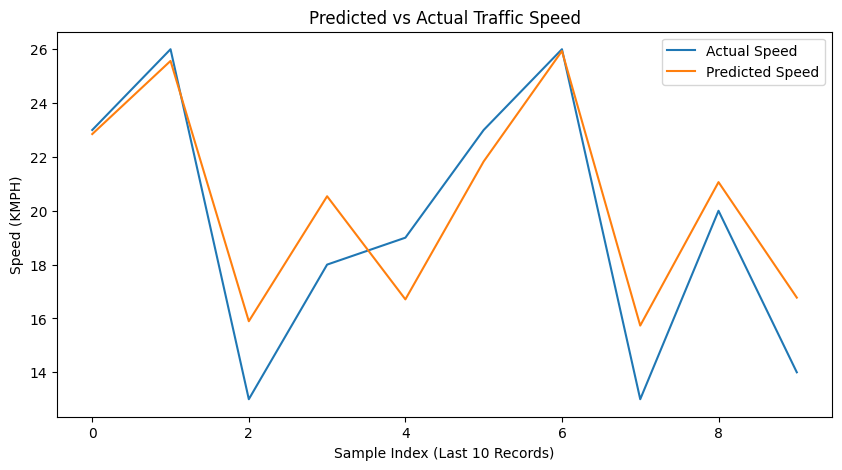

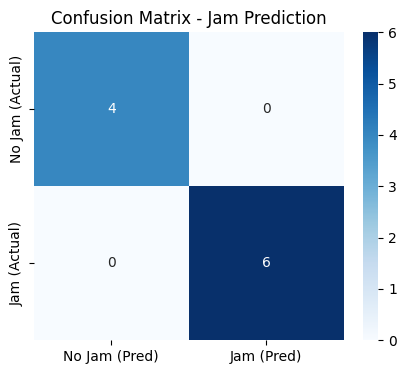

In [6]:
# -----------------------------
# 9. PREDICTIONS & METRICS
# -----------------------------
pred_speed_scaled, pred_jam = final_model.predict(X_seq_final[-10:])
pred_speed = scaler_y.inverse_transform(pred_speed_scaled).flatten()
pred_jam_class = (pred_jam.flatten() > 0.5).astype(int)

actual_speed = scaler_y.inverse_transform(y_speed_seq_final[-10:]).flatten()
actual_jam = y_jam_seq_final[-10:].flatten()

print("Predicted speeds:", pred_speed)
print("Actual speeds:", actual_speed)
print("Predicted jam (1=Jam, 0=No Jam):", pred_jam_class)
print("Actual jam:", actual_jam)

print("Accuracy (Jam Prediction):", accuracy_score(actual_jam, pred_jam_class))
print("Precision:", precision_score(actual_jam, pred_jam_class, zero_division=0))
print("Recall:", recall_score(actual_jam, pred_jam_class, zero_division=0))
print("F1 Score:", f1_score(actual_jam, pred_jam_class, zero_division=0))

speed_accuracy = np.mean(100 - (np.abs(pred_speed - actual_speed) / actual_speed * 100))
print("Speed Prediction Accuracy (%):", speed_accuracy)

# -----------------------------
# 10. VISUALIZATION
# -----------------------------
plt.figure(figsize=(10,5))
plt.plot(actual_speed, label="Actual Speed")
plt.plot(pred_speed, label="Predicted Speed")
plt.xlabel("Sample Index (Last 10 Records)")
plt.ylabel("Speed (KMPH)")
plt.title("Predicted vs Actual Traffic Speed")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(actual_jam, pred_jam_class)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Jam (Pred)", "Jam (Pred)"],
            yticklabels=["No Jam (Actual)", "Jam (Actual)"])
plt.title("Confusion Matrix - Jam Prediction")
plt.show()
